In [2]:
# A faster more concise version of Rift_retrieval 
# less interactive for cranking out calculationsa

In [2]:
import numpy as np
import sys
import logging
import concurrent.futures
import time
from datetime import datetime
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer, CRS
import shapely.geometry as sg
from shapely.geometry import Polygon, Point
from sliderule import sliderule, icesat2, earthdata, h5, ipysliderule, io
import warnings
from IPython import display
import json
import utils.toolshelf as t
import LagrangianDEMdifferencing.utils.lagrange as lagrange
from random import sample

import fiona

warnings.filterwarnings('ignore')
%matplotlib inline

/tmp/ipykernel_89/3536755958.py:8: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
####################### SET PARAMETERS #################

In [197]:
# # Select predetermined track (2 digit cycle number)
site = "filchnerF1"
cycle = '05'

# Data access options
# (-1: Skip altogether, 0: process fresh, 1: load from geojson, 2: load from csv)
accessType = 1

#input options
# resolution (recommended 20.0)
# "len" and "res" (will be equal)
res = 10.0
cnf = 2

#output options
# Save flag (0: dont save, 1: save as geojson (slow but everything works), 
# 2: save as csv (faster but nothing works))
sFlag = 0

shpPath = f"../shapes/{site}/{site}_{cycle}.geojson"
#shpPath = f"../shapes/{site}_2019-09-03_04.geojson"
#shpPath = f"../shapes/{site}.geojson"

datPath = f"../data/"
figPath = f"../figs/{site}/"
filename03 = f"{datPath}{site}_ATL03_def"
filename06 = f"{datPath}{site}_ATL06_cyc{cycle}_res{int(res)}"
filenameMel = f"{datPath}{site}_res{int(res)}/{site}_mel_cyc{cycle}_res{int(res)}"

In [198]:
########################### BEGIN ####################

In [199]:
# Configure ICESat-2 API
icesat2.init("slideruleearth.io", verbose=False)

In [200]:
# gt dictionary
global gtDict, revgtDict, geoidDefault, cycleDict
gtDict = {"gt1l": 10, "gt1r": 20, "gt2l": 30, "gt2r": 40, "gt3l": 50, "gt3r": 60}
revgtDict = {10: "gt1l", 20: "gt1r", 30: "gt2l", 40: "gt2r", 50: "gt3l", 60: "gt3r"}
geoidDefaultDict = {'ross1': -55.5, 'filchnerF1': -14.45734}
geoidDefault = geoidDefaultDict[site]
melangeCutoffDict = {'ross1': 30, 'filchnerF1': 60}
min_photonDict = {'ross1': 200, 'filchnerF1': 200}

#cycle start and end dates
cycleDict = {'01': ['2018-10-13', '2018-12-28'], '02': ['2018-12-28', '2019-03-29'], 
             '03': ['2019-03-29', '2019-06-28'], '04': ['2019-07-09', '2019-09-26'], 
             '05': ['2019-09-26', '2019-12-26'], '06': ['2019-12-26', '2020-03-26'],
             '07': ['2020-03-26', '2020-06-25'], '08': ['2020-06-25', '2020-09-24'],
             '09': ['2020-09-24', '2020-12-23'], '10': ['2020-12-24', '2021-03-24'],
             '11': ['2021-03-24', '2021-06-23'], '12': ['2021-06-23', '2021-09-22'],
             '13': ['2021-09-22', '2021-12-22'], '14': ['2021-12-22', '2022-03-23'],
             '15': ['2022-03-23', '2022-06-21'], '16': ['2022-06-21', '2022-09-20'],
             '17': ['2022-09-20', '2022-12-20'], '18': ['2022-12-20', '2023-03-21'],
             '19': ['2023-03-21', '2023-06-20'], '20': ['2023-06-20', '2023-09-19'],
             '21': ['2023-09-19', '2023-12-18'], '22': ['2023-12-18', '2024-03-18']}


cycleMonthDict = {'01': ['Oct', 'Dec'], '02': ['Dec', 'Mar'], 
             '03': ['Mar', 'Apr'], '04': ['Jun', 'Sep'], 
             '05': ['Sep', 'Dec'], '06': ['Dec', 'Mar'],
             '07': ['Mar', 'Jun'], '08': ['Jun', 'Sep'],
             '09': ['Sep', 'Dec'], '10': ['Dec', 'Mar'],
             '11': ['Mar', 'Jun'], '12': ['Jun', 'Sep'],
             '13': ['Sep', 'Dec'], '14': ['Dec', 'Mar'],
             '15': ['Mar', 'Jun'], '16': ['Jun', 'Sep'],
             '17': ['Sep', 'Dec'], '18': ['Dec', 'Mar'],
             '19': ['Mar', 'Jun'], '20': ['Jun', 'Sep'],
             '21': ['Sep', 'Dec'], '22': ['Dec', 'Mar']}

'''
File Naming Conventions
ATL[xx]_[yyyymmdd][hhmmss]_[tttt][cc][nn]_[vvv]_[rr].h5
xx : ATLAS product number
yyyymmdd : year, month and day of data acquisition
hhmmss : start time, hour, minute, and second of data acquisition
tttt : Reference Ground Track (RGT, ranges from 1–1387)
cc : Orbital Cycle (91-day period)
nn : Granule number (ranges from 1–14)
vvv : data version number
rr : data release number
'''

# Import granule id, 
def unpackGranuleID(gid):
    #global shortName, dat, tim, rgt, cycle, granuleNumber, version, release
    granID = gid[:]
    gid = gid.split('_')
    shortName = f'{gid[0]}'
    dat = f'{gid[1][0:4]}-{gid[1][4:6]}-{gid[1][6:8]}'
    tim = f'{gid[1][8:10]}:{gid[1][10:12]}:{gid[1][12:14]}'
    rgt = int(f'{gid[2][0:4]}')
    cycle = int(f'{gid[2][4:6]}')
    granuleNumber = int(f'{gid[2][6:8]}')
    version = int(f'{gid[3]}')
    release = int(f'{gid[4][0:2]}')
    return {"shortName": shortName, "date": dat, "time": tim, 
            "rgt": rgt, "cycle": cycle, "granuleNumber": granuleNumber, 
            "version": version, "release": release, "granuleID": granID}

# Get a datetime formatted for earthdata cmr search from geodataframe timestamp
def getDateTime(timestp):
    dat, tim = timestp.date(), timestp.time().strftime("%H:%M:%S")
    return f"{dat}T{tim}Z"

def displayInfo(gdf):
    print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
    print("Beams: {}".format([revgtDict[b] for b in list(gdf['gt'].unique())]))
    print("Cycles: {}".format(gdf["cycle"].unique()))
    print("Received {} elevations".format(gdf.shape[0]))
    print(f"Across {3*(len(np.unique(gdf.loc[:, 'rgt'])) + len(np.unique(gdf.loc[:, 'cycle'])))} strong tracks")
    # Exception here is only necessary when importing csv's
    try: print(f"Date range {gdf.index.min().date()} to {gdf.index.max().date()}")
    except: print(f"Date range {datetime.strptime(gdf.index.min()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}" 
        f" to {datetime.strptime(gdf.index.max()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}")
    print(f"Vertical range {gdf.h_mean.min()}m to {gdf.h_mean.max()}m")
    return

def display03Info(gdf):
    print("Reference Ground Tracks: {}".format(gdf["rgt"].unique()))
    #print("Beams: {}".format([revgtDict[b] for b in list(atl06_sr['gt'].unique())]))
    print("Spots: {}".format(gdf["spot"].unique()))
    print("Cycles: {}".format(gdf["cycle"].unique()))
    print("Received {} elevations".format(gdf.shape[0]))
    print(f"Across {3*(len(np.unique(gdf.loc[:, 'rgt'])) + len(np.unique(gdf.loc[:, 'cycle'])))} strong tracks")
    # Exception here is only necessary when importing csv's
    try: print(f"Date range {gdf.index.min().date()} to {gdf.index.max().date()}")
    except: print(f"Date range {datetime.strptime(gdf.index.min()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}" 
        f" to {datetime.strptime(gdf.index.max()[:-3], '%Y-%m-%d %H:%M:%S.%f').date()}")
    return

def getTrackList(gdf, min_photons=200, print_lens=False, verbose=True):
    rgtAll = atl06_sr["rgt"].unique()
    gtAll = atl06_sr['gt'].unique()
    cycleAll = atl06_sr["cycle"].unique()
    lens = []
    tracks=[]

    for cyc in cycleAll:
        #t = atl06_sr[atl06_sr.cycle==cyc]
        for r in rgtAll:
            #t = t[t.rgt==r]
            for g in gtAll:
                t = atl06_sr[(atl06_sr.cycle==cyc)*(atl06_sr.rgt==r)*(atl06_sr.loc[:, 'gt']==g)]
                if len(t)>min_photons:
                    tracks.append((cyc, r, revgtDict[g]))
                    lens.append(len(t))
    if print_lens: print(lens)
    if verbose:
        print(f'Finding tracks with minimum of {min_photons} photons')
        print(f'{len(lens)} found')
    return tracks

def getTrack(dat, trackInfo):
    cycle, rgt, gt = trackInfo[0], trackInfo[1], gtDict[trackInfo[2]]
    track = dat[(dat.rgt==rgt)*(dat.cycle==cycle)*(dat.loc[:, 'gt']==gt)]
    return track, cycle, rgt, gt

def geoCorrect(dat):
    # Geo correct atl03 data
    return dat['height']-dat['geoid']

# Plotting stuff
def plot06(track, save=False, titl='ATL06 Data', xlab='S-N latitude', ylab='Elevation above geoid (m)',
          xl=None, yl=None):
    try:
        fig, ax = plt.subplots(figsize=[15, 3])

        x = (track['distance']-track['distance'][0])/1000
        x = track.geometry.y
        y = track.h_mean
        if not isSeaward:
            print("Track should be reversed to seaward orientation")
            #x = (track['distance']-(track['distance'][-1]))/1000
        ax.plot(x, y, '-', color='orange', linewidth=2.5, label='ATL06-SR')

        x = (mTrack['distance']-track['distance'][0])/1000
        x = mTrack.geometry.y
        y = mTrack.h_mean
        ax.plot(x, y, '.', color='red', linewidth=2.5)#, label='ATL06-SR mélange')
        ax.set_title(titl)
        ax.set_xlabel(xlab)
        ax.set_ylabel(ylab)
        ax.set_ylim(yl)
        ax.set_xlim(xl)
        ax.legend(loc=4, frameon=False)
        info = f'ICESat-2 track {rgt}-{revgtDict[gt]}'
        plt.text(0.02, 0.05, info, horizontalalignment='left', verticalalignment='bottom',
                 transform=ax.transAxes, fontsize=10, bbox=dict(edgecolor=None, facecolor='white', alpha=0.9, linewidth=0))
        if save:
            plt.savefig(f'{figPath}melange/{site}_cyc{cycle}_rgt{rgt}-{revgtDict[gt][-2:]}_res{res}_mel.png', 
                        dpi=150, bbox_inches='tight')
            
    except: print(f"something went wrong with this track")
    
#Save elevations
def saveMelange(dat):
    datReduced = dat.loc[:, ['cycle', 'rgt', 'spot', 'h_mean', 'geometry']]
    datReduced.to_file(f"{filenameMel}.geojson", driver='GeoJSON')
    return



In [201]:
# Read in EPSG:3031 shapefile and convert to EPSG:4326
shpFile = gpd.read_file(shpPath)
shpFile.crs = 'EPSG:3031'
target_epsg = 'EPSG:4326'
shpDF = shpFile.to_crs(target_epsg)
region = sliderule.toregion(shpDF)["poly"]
#transformed_gdf.to_file(f"test.geojson", driver='GeoJSON') 

In [202]:
parms = {
    "poly": region,
    "srt": 0,
    "len": res*2,
    "res": res,
    "cnf": cnf,
    "maxi": 6,
    "ats": 5.0,
    "cnt": 5,
    "H_min_win": 3.0,
    "sigma_r_max": 5.0,
    "cycle": cycle
}

In [203]:
%%time
if accessType == 0:
    print('Processing new ATL06-SR dataset')

    # Request ATL06 Data
    print('Downloading all available data')
    atl06_sr = icesat2.atl06p(parms, "nsidc-s3")
    atl06_sr = atl06_sr[(atl06_sr.spot==2)+(atl06_sr.spot==4)+(atl06_sr.spot==6)]

    # Display Statistics
    displayInfo(atl06_sr)
    insufficientDataCache=[]

    # Save all data
    if sFlag==1:
        # save geodataframe as geojson
        print(f'Saving file as geojson named {filename06}.geojson')
        atl06_sr.to_file(f"{filename06}.geojson", driver='GeoJSON')
    elif sFlag==2:
        # Save geodataframe as csv
        print(f'Saving file as csv named {filename06}.csv')
        atl06_sr.to_csv(f"{filename06}.csv")

elif accessType==1:
    #load from geojson
    filename06 = f"{datPath}{site}_res{int(res)}/{site}_ATL06_cyc{cycle}_res{int(res)}"
    print('Downloading atl06-SR data upload from .geojson file')
    atl06_sr = gpd.read_file(f"{filename06}.geojson").set_index('time')
    displayInfo(atl06_sr)
elif accessType==2:
    # Load from csv (everything is a string)
    print('Downloading atl06-SR data upload from .csv file')
    atl06_sr = gpd.read_file(f"{filename06}.csv").set_index('time')
    displayInfo(atl06_sr)
elif accessType==-1:
    print('skipping data download altogether')

Reference Ground Tracks: [ 109  170  231  253  292  314  375  436  551  612  673  734  756 1054
 1115 1176 1198 1381]
Beams: ['gt3l', 'gt2l', 'gt1l']
Cycles: [5]
Received 16837 elevations
Across 57 strong tracks
Date range 2019-10-04 to 2019-12-26
Vertical range -201.6882594712176m to 379.49197952379126m
CPU times: user 3.9 s, sys: 19.5 ms, total: 3.92 s
Wall time: 3.92 s


In [204]:
'''
goodTracks = []
allTracks = [getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
elevMin = -5
elevMax = 100
for tr in allTracks:
    tr.h_mean -= geoidDefault
    if (tr.h_mean.max() < elevMax) and (tr.h_mean.min() > elevMin):
        #print(f'{tr.h_mean.max()}, {tr.h_mean.min()}')
        goodTracks.append(tr)
ss_atl06_sr = pd.concat(goodTracks)
'''

"\ngoodTracks = []\nallTracks = [getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]\nelevMin = -5\nelevMax = 100\nfor tr in allTracks:\n    tr.h_mean -= geoidDefault\n    if (tr.h_mean.max() < elevMax) and (tr.h_mean.min() > elevMin):\n        #print(f'{tr.h_mean.max()}, {tr.h_mean.min()}')\n        goodTracks.append(tr)\nss_atl06_sr = pd.concat(goodTracks)\n"

In [205]:
#track choice method (0: drop photons (not valid technique), 1: drop whole tracks)
trackMethod = 1

if trackMethod==0:
    # separate all good tracks and put them into a list
    trackList = getTrackList(atl06_sr, min_photons=min_photonDict[site], print_lens=False)
    ss_atl06_sr = pd.concat([getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList])

    #Geoid and outliers
    # for ross limits good limits are
    print('correcting for geoid, scraping outliers')
    ss_atl06_sr.h_mean -= geoidDefault
    ss_atl06_sr = ss_atl06_sr[(ss_atl06_sr.h_mean<100)*(ss_atl06_sr.h_mean>-5)]

    melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<melangeCutoffDict[site]]
    ss_atl06_sr_list = [getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
    displayInfo(ss_atl06_sr)
    saveMelange(melange_sr)
    
if trackMethod==1:
    
    trackList = getTrackList(atl06_sr, min_photons=min_photonDict[site], print_lens=False)
    
    goodTracks = []
    goodMel = []
    allTracks = [getTrack(atl06_sr, trackInfo)[0] for trackInfo in trackList]
    #Ross
    elevMin = -5
    elevMax = 100
    melMinPoints = 100
    #filchner 
    elevMin = -2
    elevMax = 100
    melMinPoints = 100
    for tr in allTracks:
        tr.h_mean -= geoidDefault
        if (tr.h_mean.max() < elevMax) and (tr.h_mean.min() > elevMin):
            #print(f'{tr.h_mean.max()}, {tr.h_mean.min()}')
            mel = tr[tr.h_mean<melangeCutoffDict[site]]
            if len(mel) > melMinPoints: 
                goodMel.append(mel)
                goodTracks.append(tr)
            
    ss_atl06_sr = pd.concat(goodTracks)
    melange_sr = pd.concat(goodMel)
    
    #melange_sr = ss_atl06_sr[ss_atl06_sr.h_mean<melangeCutoffDict[site]]
    ss_atl06_sr_list = [getTrack(ss_atl06_sr, trackInfo)[0] for trackInfo in trackList]
    displayInfo(ss_atl06_sr)
    goodTrackList = getTrackList(ss_atl06_sr, print_lens=False)
    saveMelange(melange_sr)

Finding tracks with minimum of 200 photons
35 found
Reference Ground Tracks: [ 109  231  253  314  375  612  673 1054 1115 1176 1198]
Beams: ['gt2l', 'gt1l', 'gt3l']
Cycles: [5]
Received 13007 elevations
Across 36 strong tracks
Date range 2019-10-04 to 2019-12-14
Vertical range 11.810047838175246m to 90.96356051308204m
Finding tracks with minimum of 200 photons
35 found


In [94]:
# Plot every 40 points from tracklist to not slow down the notebook
projection = 'South'
max_plot_points = atl06_sr.shape[0]
cpoint = atl06_sr.iloc[1000].geometry
m = ipysliderule.leaflet(projection, center=[cpoint.x, cpoint.y], zoom=10, scroll_wheel_zoom=True)
m.GeoData(ss_atl06_sr.iloc[::40], column_name='h_mean', cmap='viridis', max_plot_points=max_plot_points)
display.display(m.map)

Map(center=[-90, 0], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_tex…

0, (5, 109, 'gt3l')
161
something went wrong with this track
1, (5, 109, 'gt2l')
0
2, (5, 109, 'gt1l')
115
3, (5, 231, 'gt3l')
138
4, (5, 231, 'gt2l')
197
5, (5, 231, 'gt1l')
154
something went wrong with this track
6, (5, 253, 'gt3l')
0
7, (5, 253, 'gt2l')
103
something went wrong with this track
8, (5, 314, 'gt3l')
0
9, (5, 314, 'gt2l')
281
10, (5, 314, 'gt1l')
271
11, (5, 375, 'gt3l')
229
12, (5, 375, 'gt2l')
176
13, (5, 375, 'gt1l')
229
14, (5, 436, 'gt2l')
248
something went wrong with this track
15, (5, 436, 'gt1l')
0
something went wrong with this track
16, (5, 551, 'gt2l')
0
something went wrong with this track
17, (5, 551, 'gt1l')
0
something went wrong with this track
18, (5, 612, 'gt3l')
0
19, (5, 612, 'gt2l')
216
20, (5, 673, 'gt3l')
251
21, (5, 673, 'gt2l')
244
22, (5, 673, 'gt1l')
230
23, (5, 1054, 'gt3l')
179
24, (5, 1054, 'gt2l')
132
25, (5, 1054, 'gt1l')
186
26, (5, 1115, 'gt3l')
241
27, (5, 1115, 'gt2l')
282
28, (5, 1115, 'gt1l')
275
29, (5, 1176, 'gt3l')
257
30, (5, 

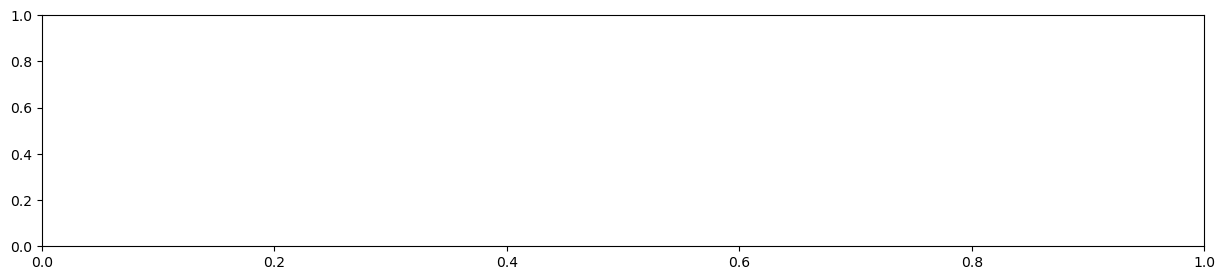

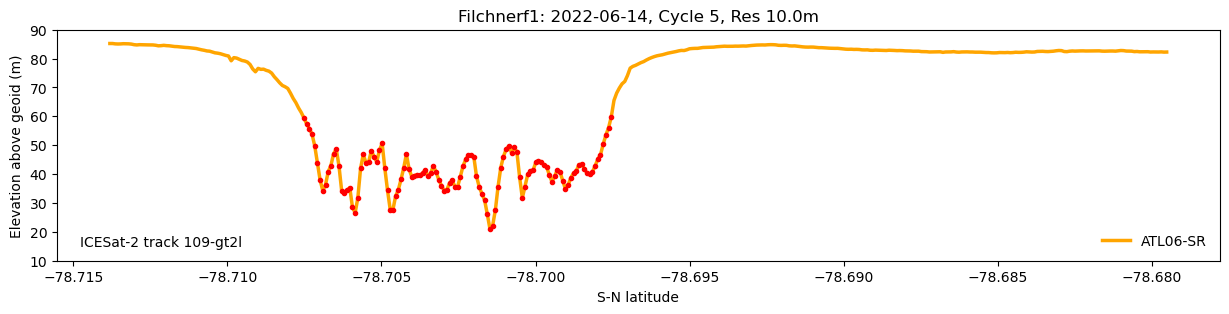

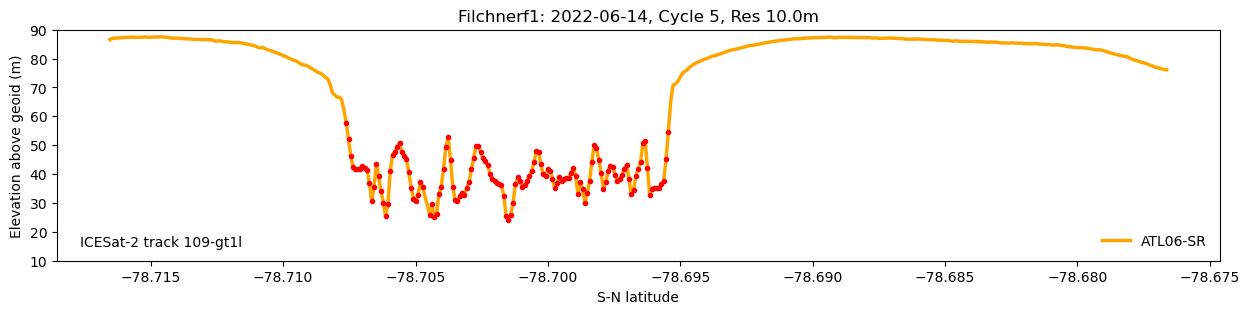

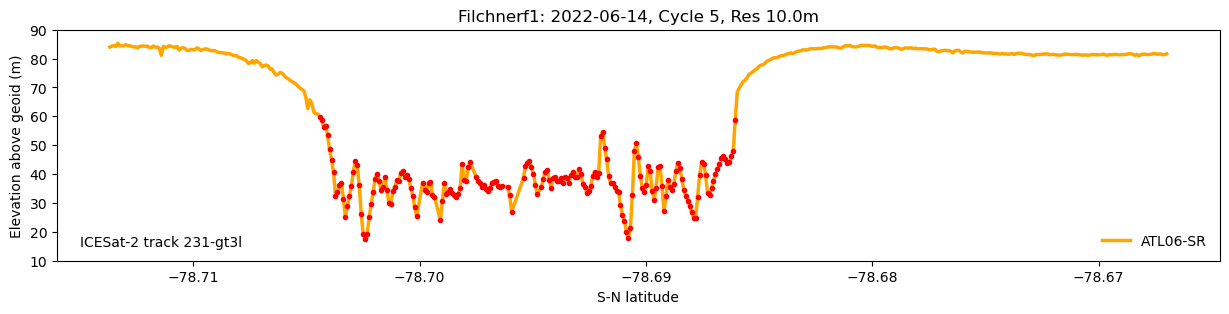

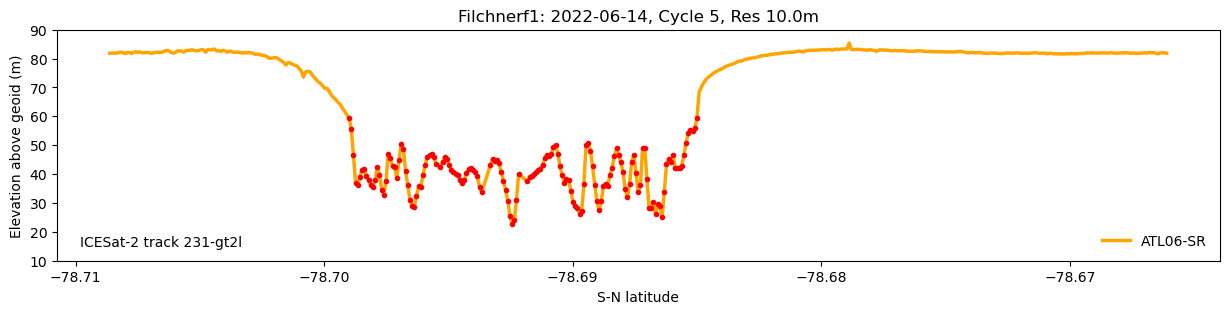

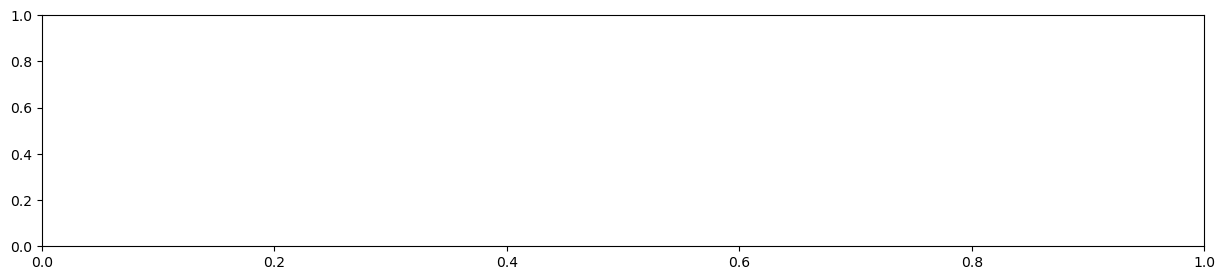

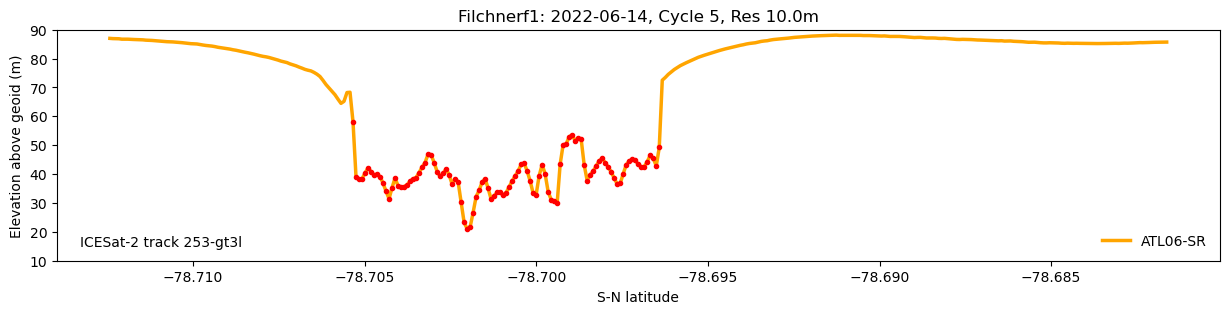

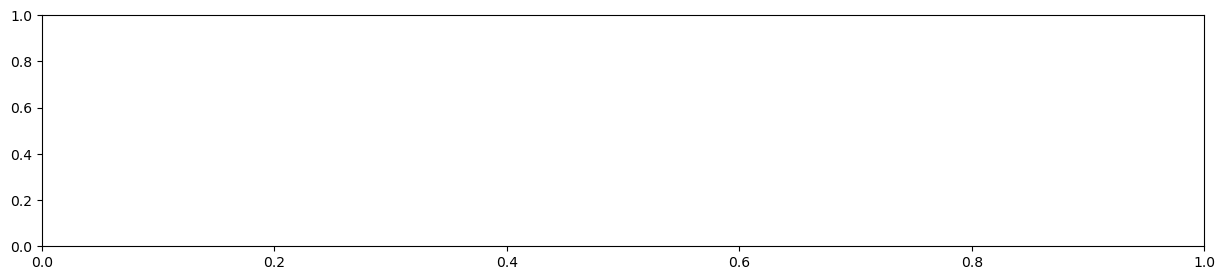

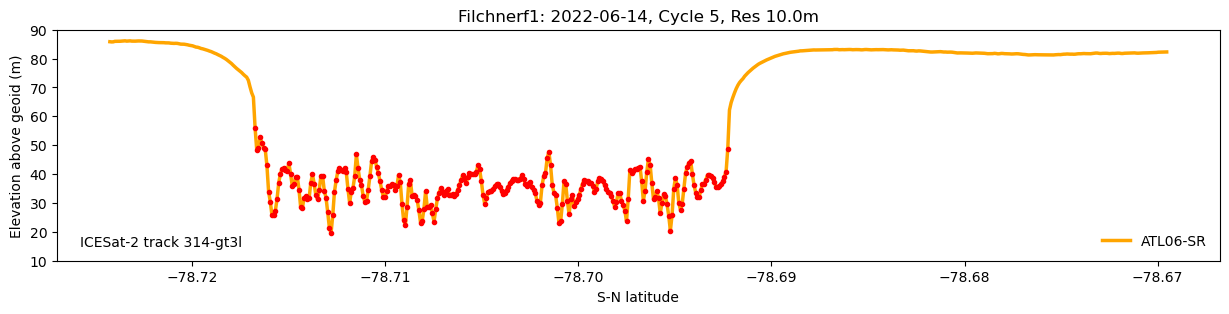

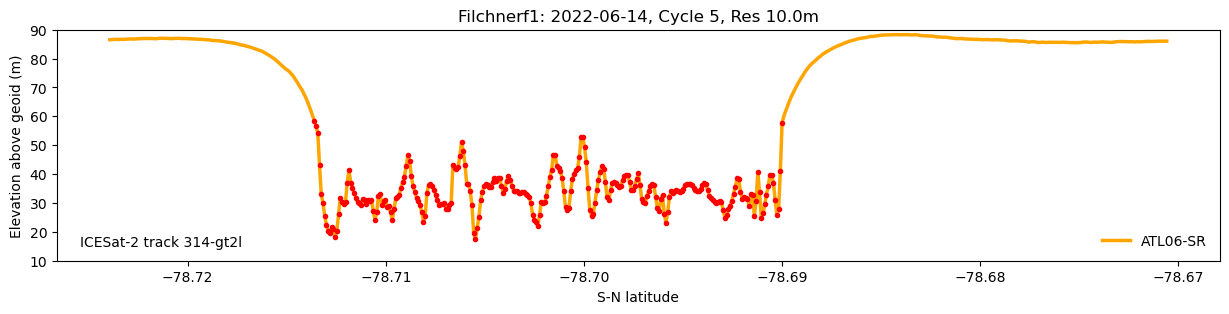

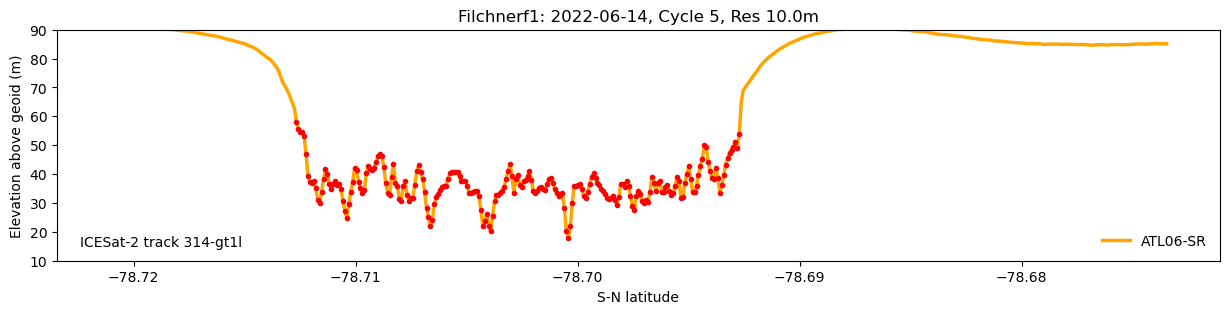

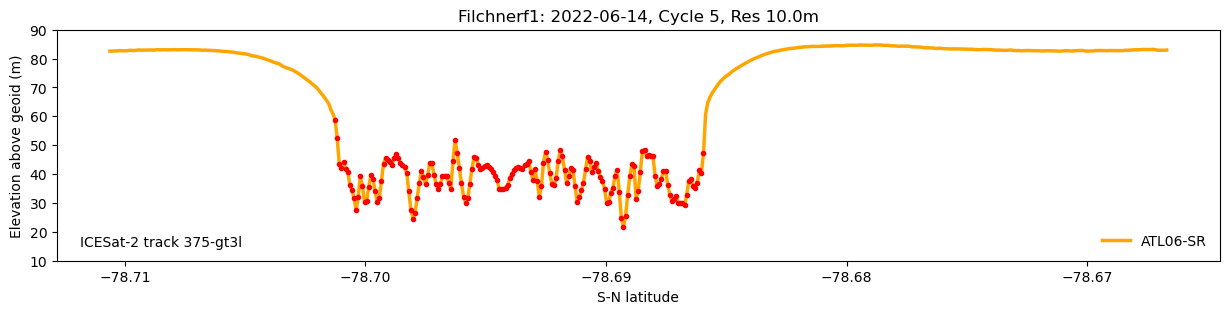

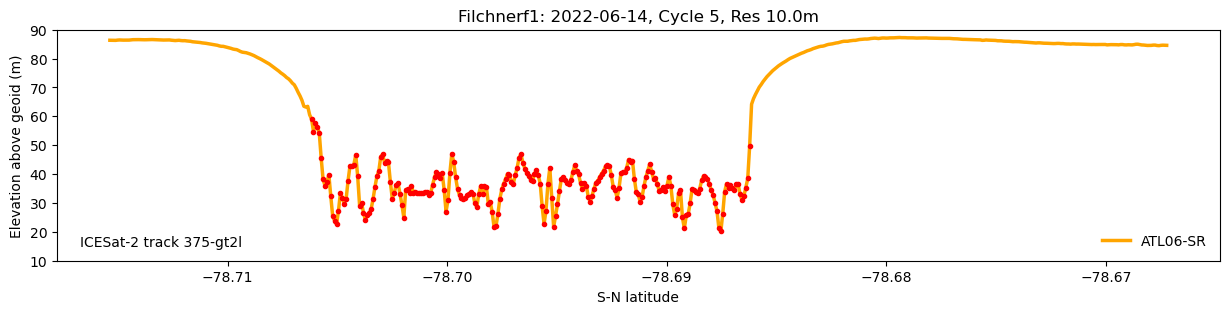

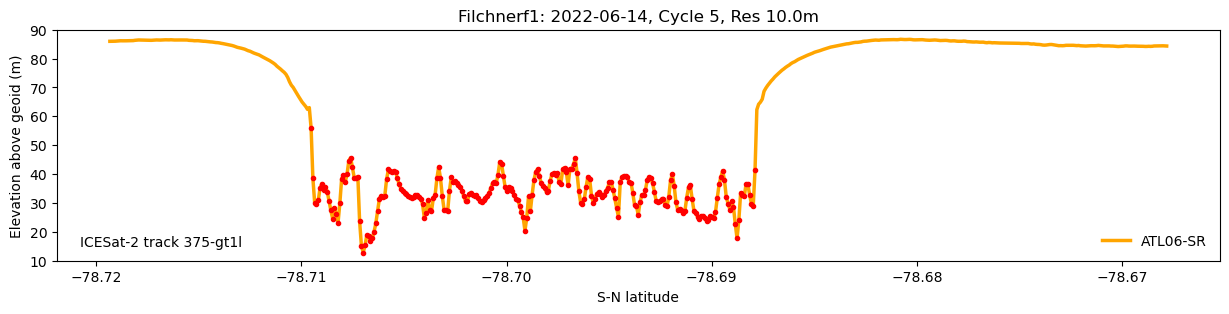

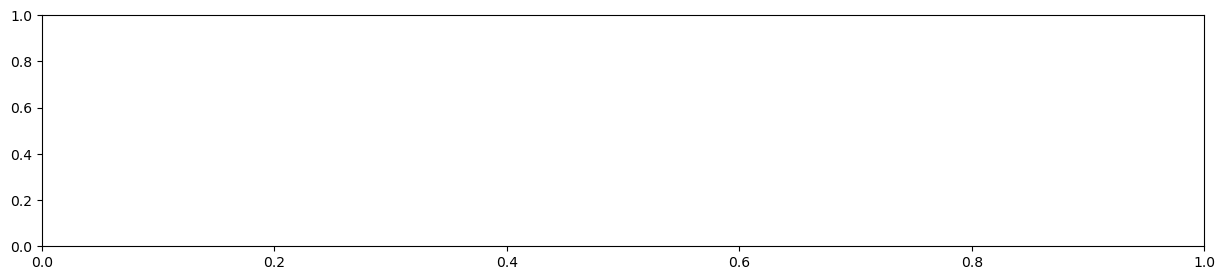

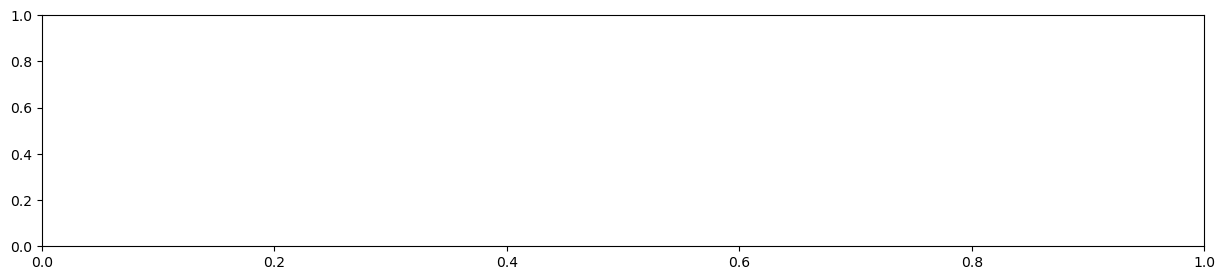

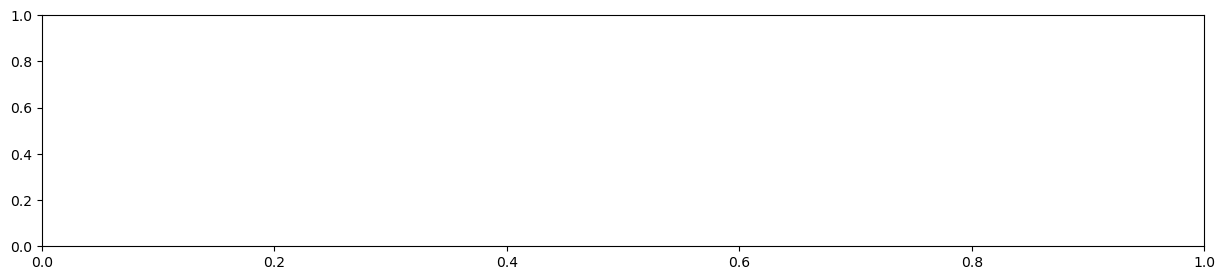

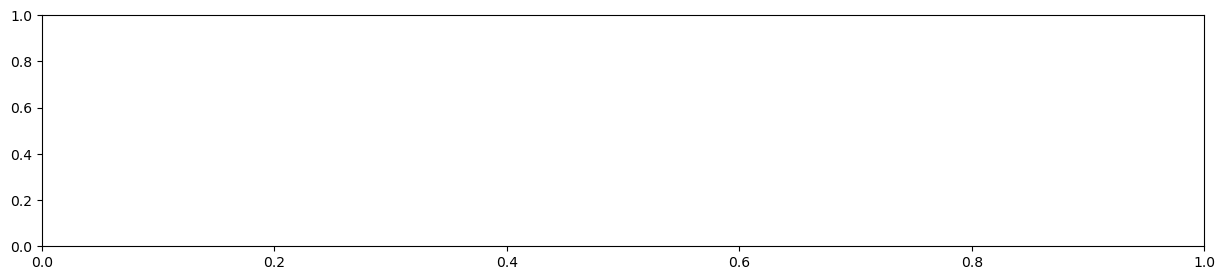

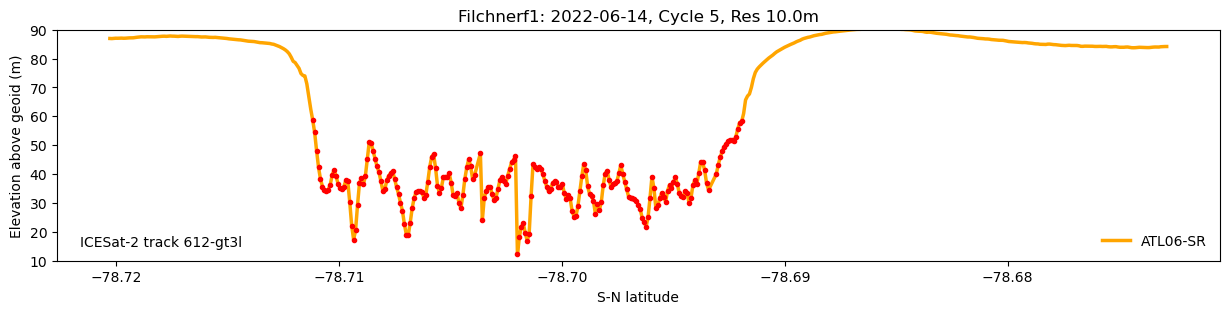

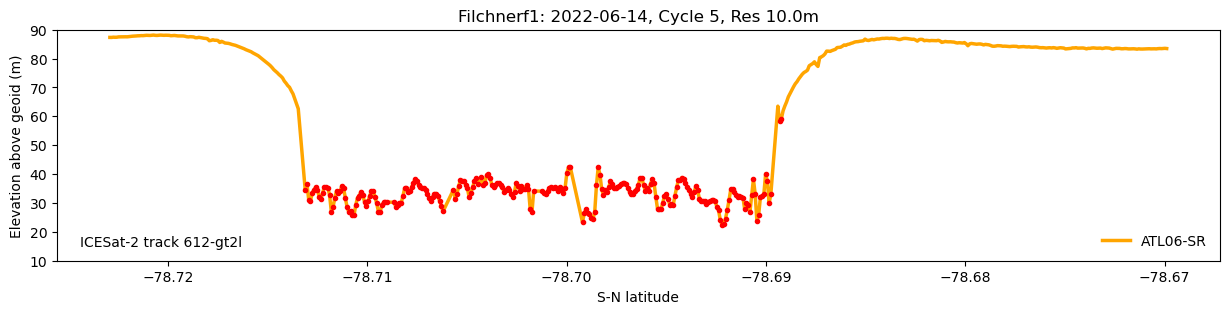

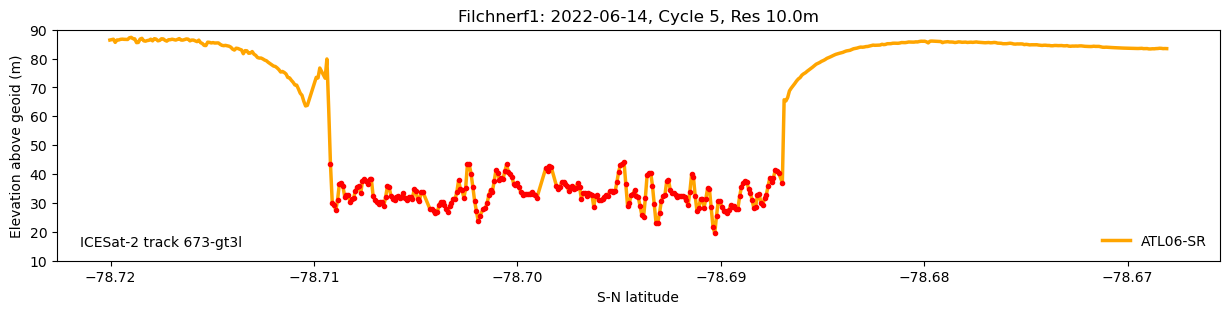

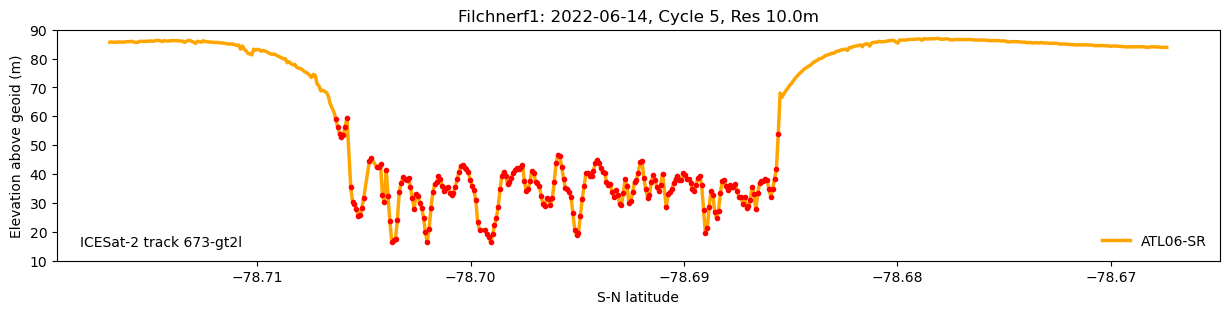

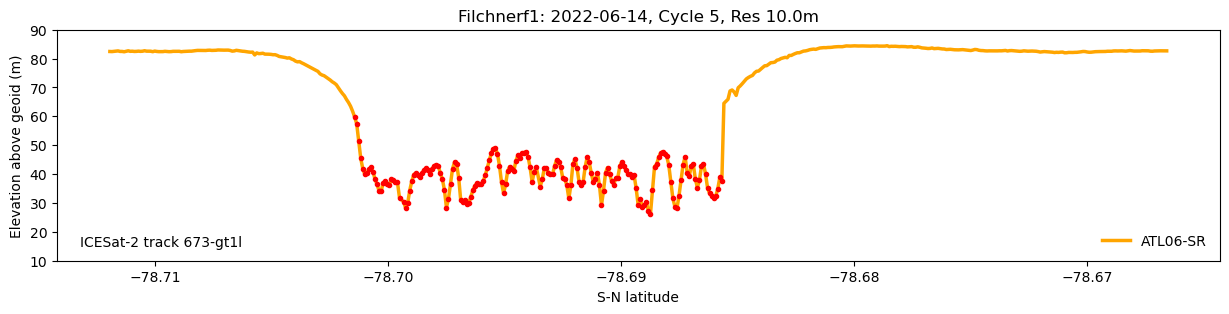

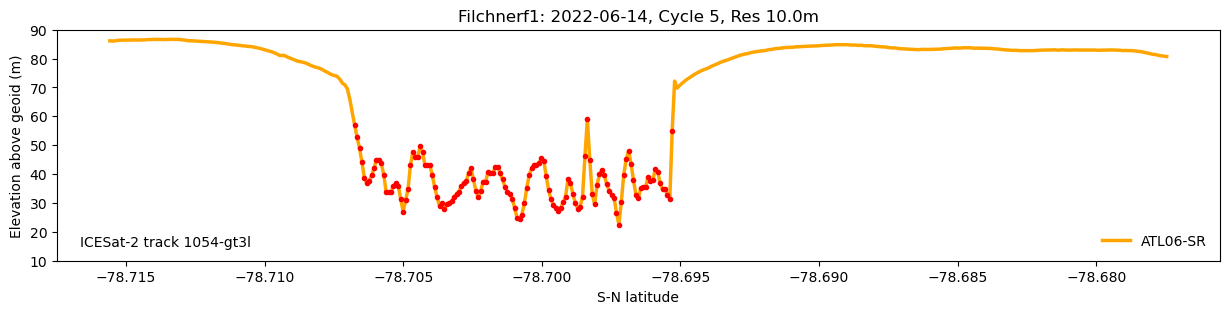

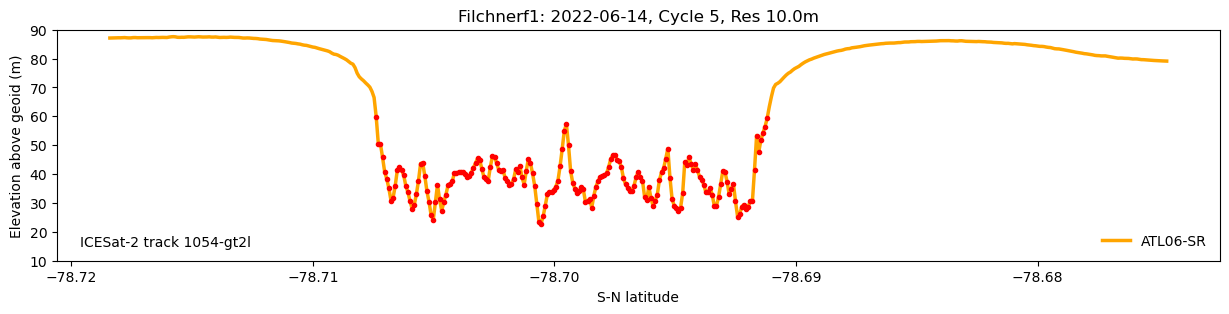

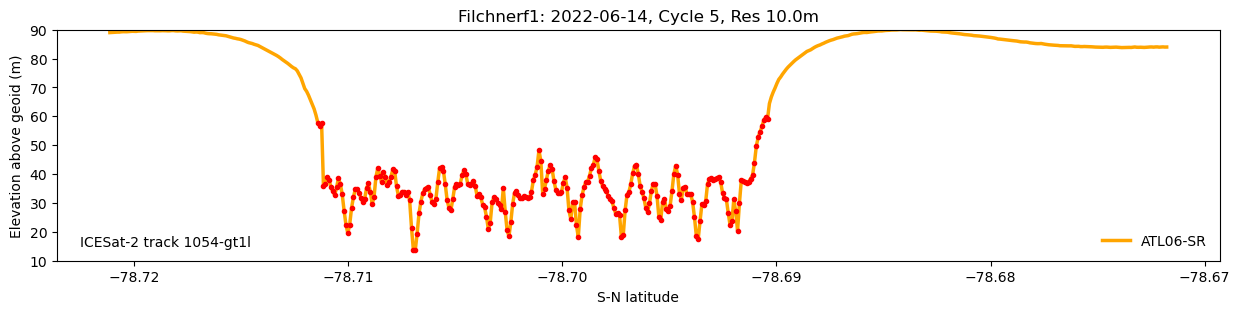

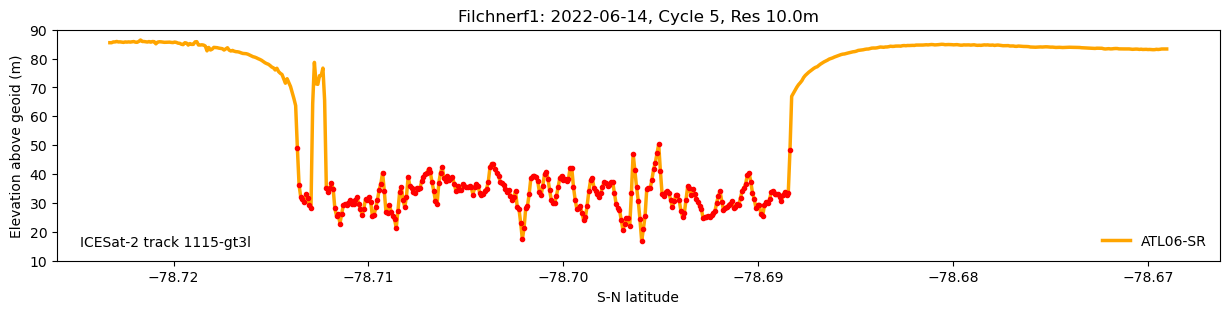

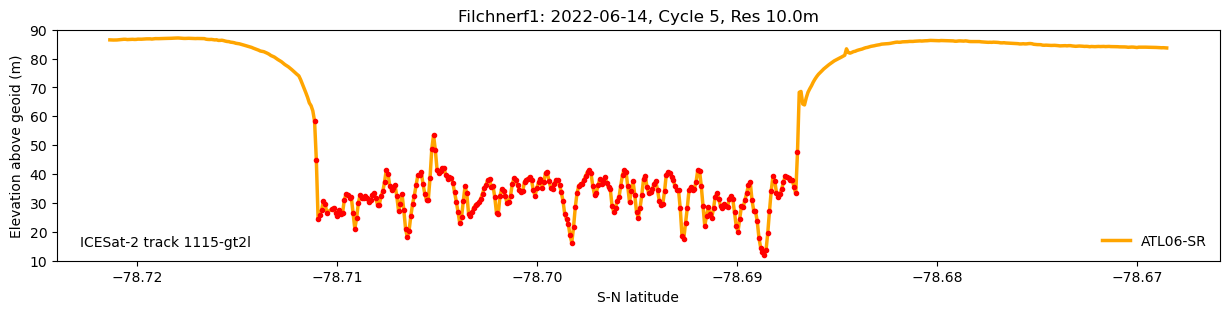

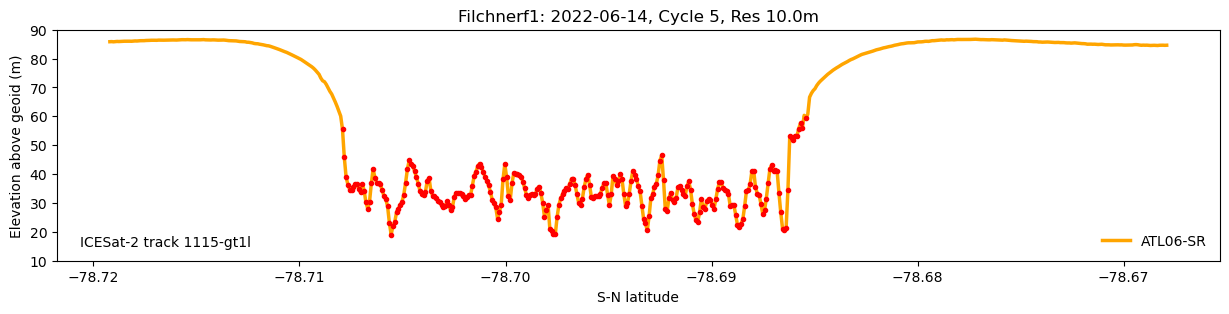

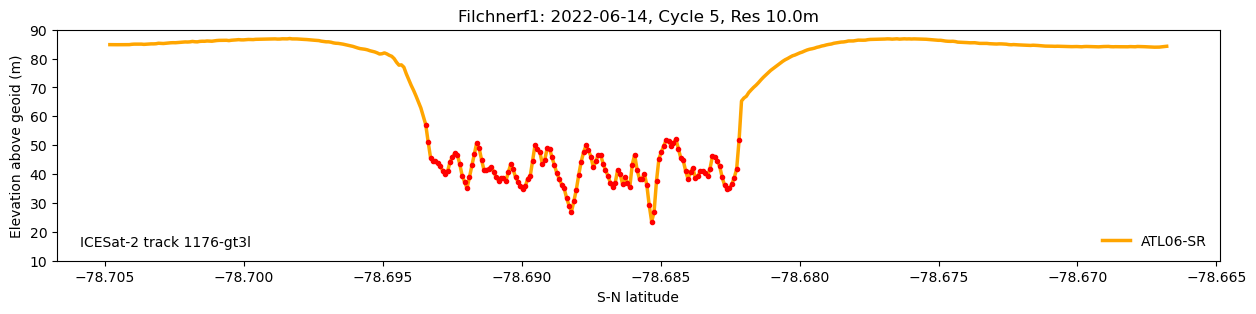

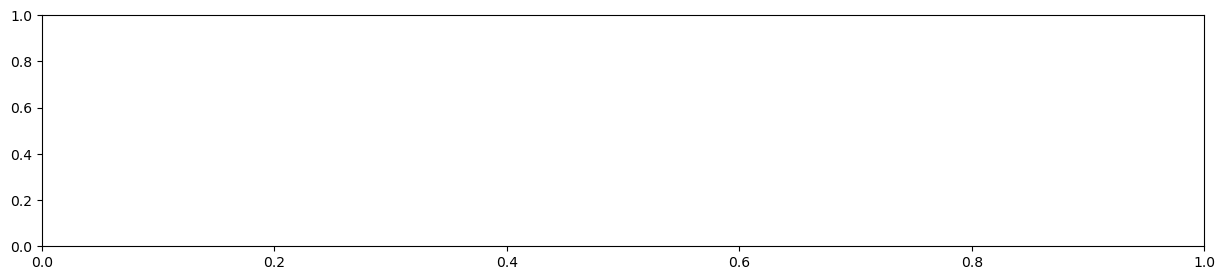

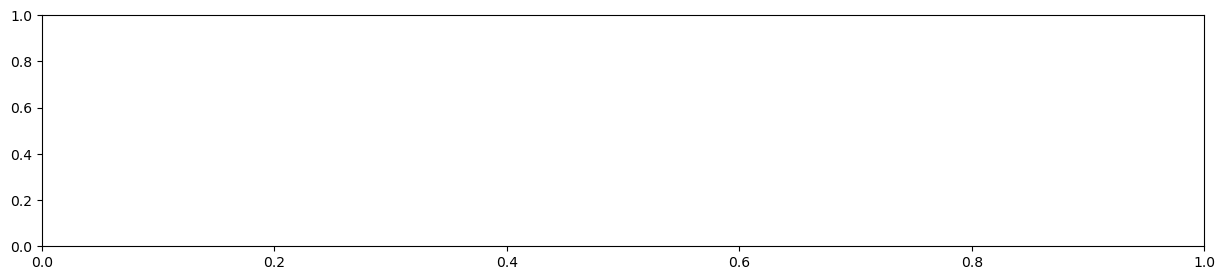

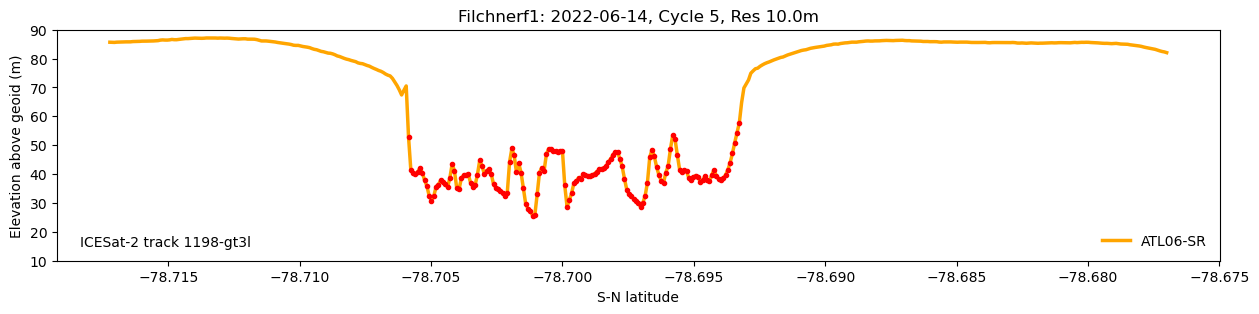

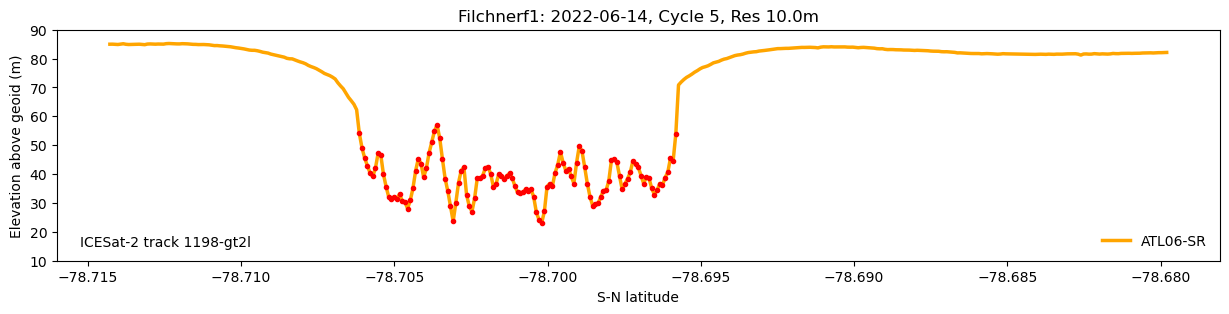

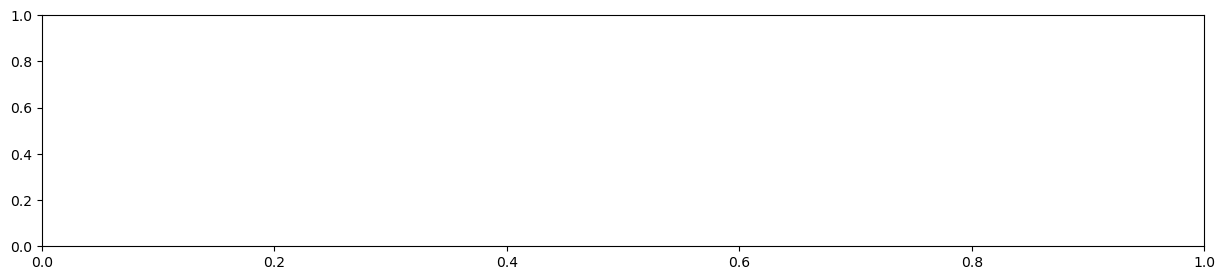

In [206]:
# Plot method (0: random track, 1: everything)
plotMethod = 1
if plotMethod==0:
    trackInfo = sample(trackList, 1)[0]
    track, cycle, rgt, gt = getTrack(ss_atl06_sr, trackInfo)
    mTrack, cycle, rgt, gt = getTrack(melange_sr, trackInfo)

    try: 
        isSeaward = track.geometry.y.iloc[0]< track.geometry.y.iloc[10]
        dat = track.index.min().date()
        print(f"Randomly selected track: Site {site}, {dat}, Cycle {cycle}, RGT {rgt}, Beam {revgtDict[gt]}")
        print(f"Contains {len(track)} photons")
    except: 
        print(f"Exception: Random track Site {site}, {dat}, Cycle {cycle}, RGT {rgt}, Beam {revgtDict[gt]} does not contain enough data")
        if rgt not in insufficientDataCache: insufficientDataCache.append([rgt, revgtDict[gt]])
        print(f"Insufficient data cache: {insufficientDataCache}")
        
    titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
    xlab = 'S-N latitude'
    ylab = 'Elevation above geoid (m)'
    yl = [-8, 60]
    plot06(track, save=False, titl=titl, xlab=xlab, ylab=ylab, yl=yl)
    
elif plotMethod==1:
    count=0
    
    for t in goodTrackList:
        print(f"{count}, {t}")
        print(f"{len(mTrack)}")
        count+=1
        
        track, cycle, rgt, gt = getTrack(ss_atl06_sr, t)
        mTrack, cycle, rgt, gt = getTrack(melange_sr, t)
        
        
        titl = f"{site.capitalize()}: {dat}, Cycle {cycle}, Res {res}m"
        xlab = 'S-N latitude'
        ylab = 'Elevation above geoid (m)'
        yl = None#[-8, 60]
        yl= [10, 90]
        plot06(track, save=True, titl=titl, xlab=xlab, ylab=ylab, yl=yl)